In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, random_accuracy, maj_class_accuracy, best_accuracy
from network import null_graph, get_alphas
from related_works import colearning, lafond_FW
from optimization import graph_discovery, gd_reg_local_FW, local_FW, global_regularized_local_FW, centralized_FW
from utils import load_computer, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 10000
n = 28
K = 190

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_computer(path="../datasets/")
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [3]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [4]:
from optimization import graph_discovery, kalo_graph_discovery
Q = 10
STEP = 500

init_w = graph_discovery(local_nodes, Q)
gd_nodes = deepcopy(nodes)
results["Dada gd"] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"uniform", "pace_gd": STEP,
        "args":(Q, )}, beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

In [5]:

b = 100
STEP = 500

init_w = kalo_graph_discovery(local_nodes, MU, b)
gd_nodes = deepcopy(nodes)

results["Dada gd kalo"] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, b)}, beta=BETA, mu=MU, nb_iter=NB_ITER, reset_step=False, monitors=monitors, checkevery=100)

In [8]:
# using graph learned with kalo
results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, 
    results["Dada gd kalo"][-1]["adj-matrix"], results["Dada gd kalo"][-1]["similarities"], mu=1, 
    max_samples_per_node=max_nb_instances)

# Accuracy and Convergence

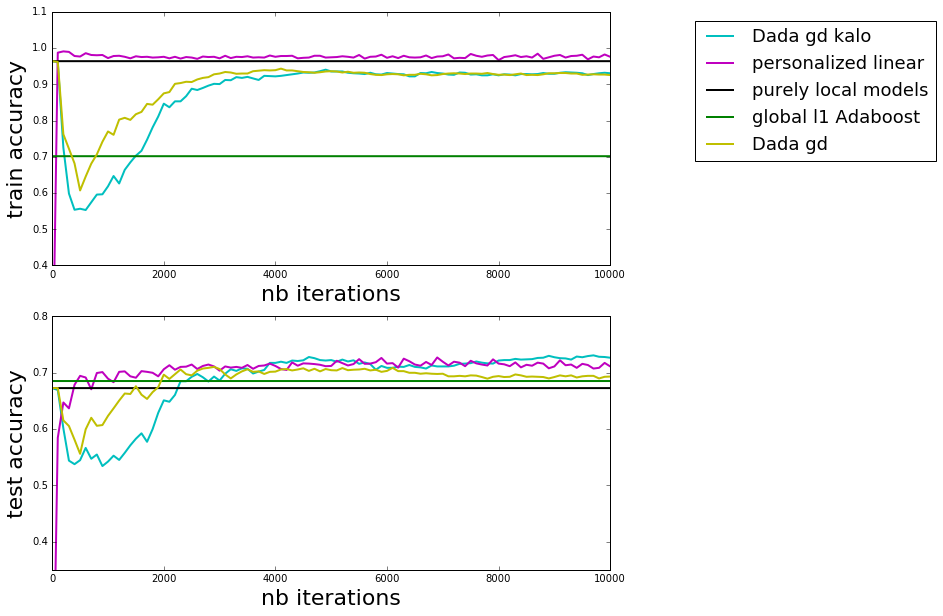

In [10]:
plt.figure(1, figsize=(10, 10))

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "Dada gd": "y",
    "personalized linear": "m", 
    "Dada gd kalo": "c"
}

max_iter = NB_ITER
plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1.1)

for k, r_list in results.items():
    try:
        c = 100
        plt.plot([i*c for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['train-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(bbox_to_anchor=(1.6, 1), fontsize=18)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.35, 0.8)

for k, r_list in results.items():
    try:
        c = 100
        plt.plot([i*c for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(max_iter+1), [r_list['test-accuracy']]*(max_iter+1), label='{}'.format(k), color=colors[k], linewidth=2)

# plt.legend(loc='lower right', fontsize=18)

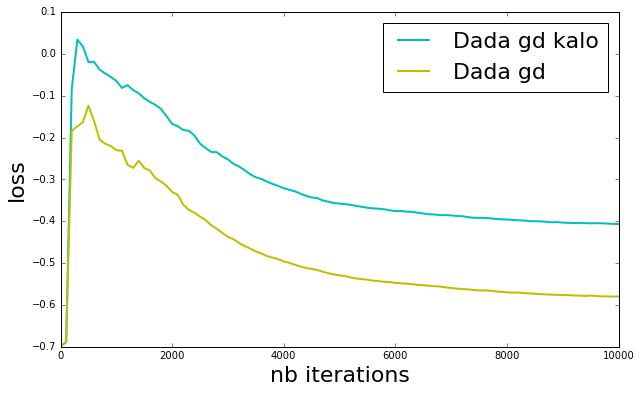

In [11]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(10, 6))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

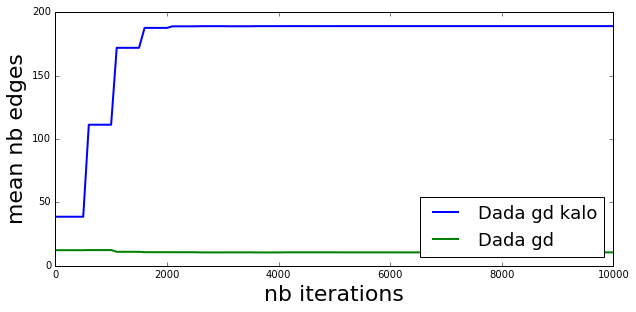

In [12]:
max_iter = NB_ITER

plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
# plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

## Graph visualization

In [13]:
import networkx as nx

kalo_graph = nx.from_numpy_matrix(results["Dada gd kalo"][NB_ITER // STEP * STEP // 100]["adj-matrix"])
uniform_graph = nx.from_numpy_matrix(results["Dada gd"][NB_ITER // STEP * STEP // 100]["adj-matrix"])

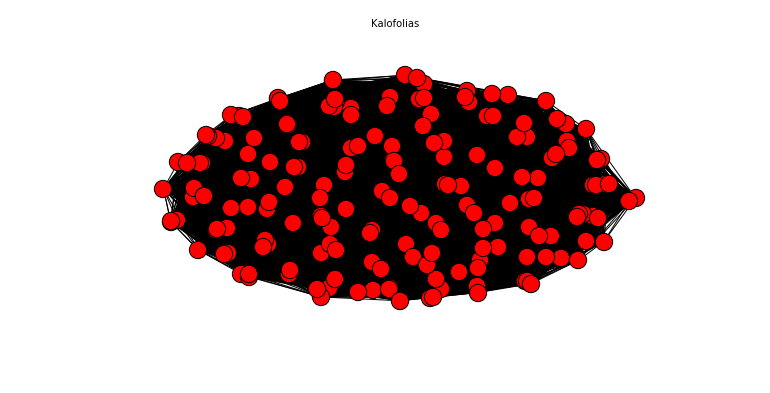

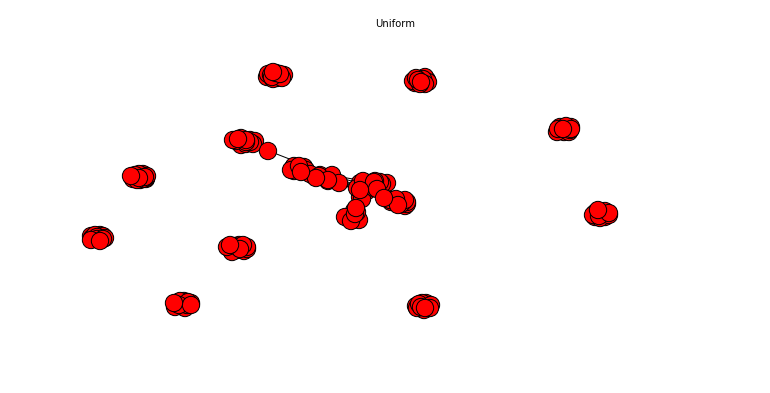

In [14]:
plt.figure(1, figsize=(10, 5))
plt.suptitle('Kalofolias')
nx.draw(kalo_graph)

plt.figure(2, figsize=(10, 5))
plt.suptitle('Uniform')
nx.draw(uniform_graph)

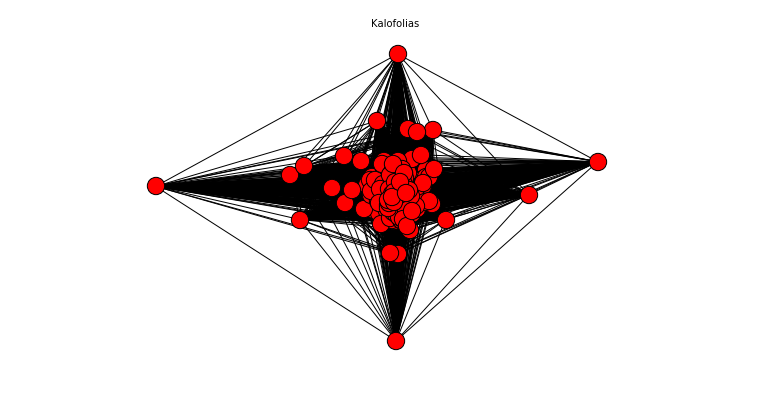

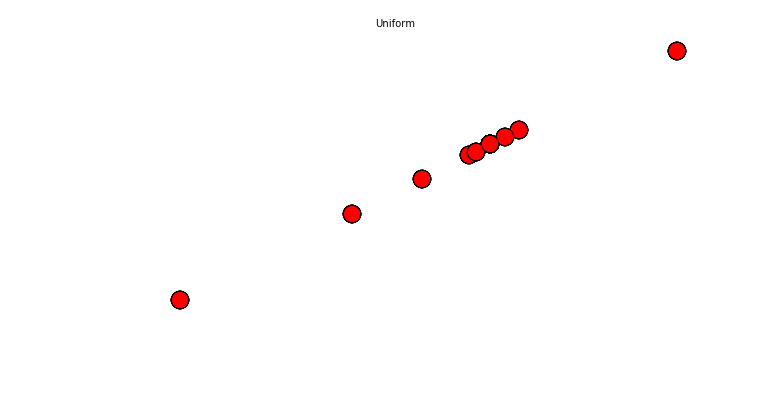

In [15]:
# communities
plt.figure(1, figsize=(10, 5))
plt.suptitle('Kalofolias')
nx.draw_spectral(kalo_graph)

plt.figure(2, figsize=(10, 5))
plt.suptitle('Uniform')
nx.draw_spectral(uniform_graph)

## Accuracy vs Sparsity

In [20]:
results_kalo = {}

gd_pace = 500

for b in [10**i for i in range(-3, 3)]:
    print(b)
    init_w = kalo_graph_discovery(local_nodes, MU, b)
    gd_nodes = deepcopy(local_nodes)
    gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, b)},
                    beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors={})
    results_kalo["(mu, b) = ({}, {})".format(MU, b)] = {}
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["train-accuracy"] = central_train_accuracy(gd_nodes)
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["test-accuracy"] = central_test_accuracy(gd_nodes)        
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["mean-edges"] = np.mean(edges(gd_nodes))

0.001
0.01
0.1
1
10
100


In [24]:
for b in [0.0001, 1000]:
    print(b)
    init_w = kalo_graph_discovery(local_nodes, MU, b)
    gd_nodes = deepcopy(local_nodes)
    gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, b)},
                    beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors={})
    results_kalo["(mu, b) = ({}, {})".format(MU, b)] = {}
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["train-accuracy"] = central_train_accuracy(gd_nodes)
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["test-accuracy"] = central_test_accuracy(gd_nodes)        
    results_kalo["(mu, b) = ({}, {})".format(MU, b)]["mean-edges"] = np.mean(edges(gd_nodes))

0.0001
1000


In [21]:
# sort reaults
train = {}
test = {}
for k, value in results_kalo.items():
    try:
        train[value["mean-edges"]].append(value["train-accuracy"])
    except:
        train[value["mean-edges"]] = [value["train-accuracy"]]
    
    try:
        test[value["mean-edges"]].append(value["test-accuracy"])
    except:
        test[value["mean-edges"]] = [value["test-accuracy"]]

train_sorted_keys = sorted(train.keys())    
test_sorted_keys = sorted(test.keys())    

{16.399999999999999: [0.93532338308457708], 36.736842105263158: [0.90831556503198296], 24.147368421052633: [0.93674484719260842], 57.989473684210523: [0.89267945984363894], 189.0: [0.92892679459843641], 20.747368421052631: [0.94527363184079605]}
{16.399999999999999: [0.71082323443376516], 36.736842105263158: [0.73422482239866271], 24.147368421052633: [0.72962808190555783], 57.989473684210523: [0.69536147095695777], 189.0: [0.73338905139991639], 20.747368421052631: [0.72586711241119928]}


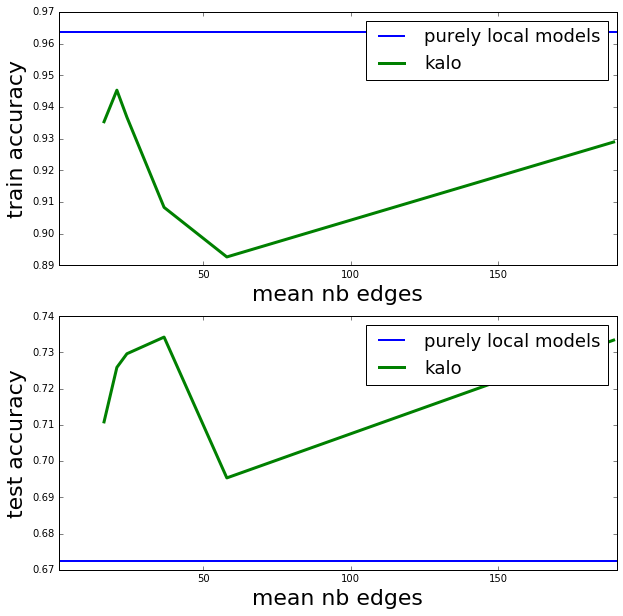

In [23]:
plt.figure(1, figsize=(10, 10))

print(train)
plt.subplot(211)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(1, 190)
# plt.ylim(0.5, 1.1)

plt.plot([1, 190], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
plt.plot(train_sorted_keys, [np.mean(train[k]) for k in train_sorted_keys], label='kalo', linewidth=3)
# plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)

plt.legend(loc='upper right', fontsize=18)

print(test)
plt.subplot(212)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(1, 190)
# plt.ylim(0.5, 1.1)

plt.plot([1, 190], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2)
plt.plot(test_sorted_keys, [np.mean(test[k]) for k in test_sorted_keys], label='kalo', linewidth=3)

plt.legend(loc='upper right', fontsize=18)